# Anovos Use Case - Credit Risk

## Table of Contents
- [Introduction](#Introduction)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Feature Identification](#Feature-Identification)
- [Data Transformation](#Data-Transformation)
- [Dimensionality Reduction](#Dimensionality-Reduction)
- [Summary](#Summary)

## Introduction
Anovos is an open source library for feature engineering at scale. It covers various essential steps in ML pipeline such as exploratory data analysis, anomaly detection, missing value imputation, categorical encoding, drift detection etc.
![anovos](assets/img/anovos_intro.png)

### Objective
In this notebook, we will use Anovos to solve a business problem from [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/overview). **The goal of the said problem is to predict the capability of the applicants to repay their loan** based on external credit rating, personal information, past loan sanction information etc.


### Workflow
Here is an overview of the workflow:
![workflow](assets/img/workflow1.png)
Throughout the demo, you may find the following resources helpful:
* API documentation: https://docs.anovos.ai/api/
* Example notebooks: https://github.com/anovos/anovos/tree/main/examples/notebooks

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Setting up
Before all the analysis, let's set up the working environment. 

Environment set up involves installing anovos by pip method which will ensure all dependencies are rightly installed in your local working environment

In [2]:
# (Optional) you can install Anovos by running the following command:
#!pip install anovos

In [3]:
# Setup the SparkSession
from anovos.shared.spark import spark, sc
sc.setLogLevel('ERROR')

In [4]:
input_path = "./data/"
output_path = "./data/output/"

### Load the data
The [dataset](https://www.kaggle.com/c/home-credit-default-risk/data?select=application_train.csv) is originally taken from Kaggle but tweaked slightly to showcase the wider functionalities of Anovos.

In [5]:
from anovos.data_ingest.data_ingest import read_dataset
df = read_dataset(spark, file_path=input_path+'application_train_modified.csv',
                  file_type='csv', file_configs={'header': 'True', 'delimiter': ',', 'inferSchema': 'True'})
df.limit(5).toPandas()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0   
1  ...                 0                0                0   
2  ...                 0                0                0   
3  ...                 0                0                0   
4  ...                 0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  DateOfBirth  
0                        0.0                         1.0   1996-02-06  
1                        0.0                         0.0   1976-02-07  
2                        0.0                         0.0   1969-11-09  
3                        NaN                         NaN   1969-12-20  
4                        0.0                         0.0   1967-06-07  

[5 rows x 123 columns]

## Exploratory Data Analysis (EDA)
EDA is an important step in feature engineering. Anovos can perform EDA in 2 ways: a) By leveraging the auto-generated reports, and b) By calling individual functions from `data_analyzer` module.

### EDA using auto-generated reports
`data_report` module can auto-generate 2 types of HTML reports: basic report and full report.

The **basic report** contains the following components:
- Descriptive Statistics
- Quality Checks - missing values, outliers, invalid entries, etc
- Attribute Associations

The **full report** contains the components provided in the basic report and the following:
- Executive Summary
- Wiki: data and metric dictionaries
- Attribute Visualizations
- Data Drift & Stability Index (if applicable)

In [24]:
# Select columns for the analysis
cols_sample = ['SK_ID_CURR', 'TARGET', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'FLAG_CONT_MOBILE', 'FLAG_PHONE','CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_CITY_NOT_WORK_CITY']
from anovos.data_ingest.data_ingest import select_column
df_sample = select_column(df.sample(False, 0.033, 13), list_of_cols=cols_sample)

#### Basic report
`anovos_basic_report` function from data_report/basic_report_generation can be used to generate the basic report. 

*Input* <br>
ID & Label columns can be passed through arguments (id_col and label_col) if they are available. If they are not mentioned, the basic report can still be generated but there will be no insights related to information value and information gain under Attribute Associations section.

In the dataset we are currently working on, `SK_ID_CURR` (ID of the loan) is the ID column and `TARGET` (Target variable: 1 - client with payment difficulties, 0 - all other cases) is the Label column so we can specify the ID & Label details in the function call.

*Output* <br>
A pre-saved report can be found in folder **assets/reports/basic_report.html** for your reference. <br>
You can also generate the same report by running the cell below. After it finishes running, an HTML report will be opened automatically in the browser. If you are unable to load the web page in Safari, you may try using Chrome instead. The report is also accessable at _data/output/data_report/report_stats/basic_report.html_. For Docker, please download the report and open using browser.

In [7]:
from anovos.data_report.basic_report_generation import anovos_basic_report
report_path = output_path+"data_report/report_stats/"

#Option 1 (with ID & Label Column)
anovos_basic_report(spark, df_sample, id_col='SK_ID_CURR', label_col="TARGET", 
                    event_label=1, output_path=report_path, print_impact=False)

#Option 2 (without ID & Label Column)
#anovos_basic_report(spark, df_sample, output_path=report_path, print_impact=False)

2022-03-24 14:41:05,511 INFO [histogram_filler_base]: Filling 435 specified histograms. auto-binning.
100%|█████████████████████████████████████████████████████████████| 435/435 [00:24<00:00, 17.46it/s]
2022-03-24 14:42:10,981 WARNING [files_optional]: Bokeh version 2.4.2 is not supported, your plots may not display correctly, please install version ~=2.2.0


Report saved to ./data/output/data_report/report_stats/basic_report.html. To host and share securely, [request a free private workspace](https://datapane.com/teams/)

----------
Before generating the  full report, it is pre-requisite to call `anovos_basic_report` and `charts_to_objects` to convert all charts to objects. Instead of calling `anovos_basic_report`, alternatively we can call the individual functions and save the statistics in report_path (master_path)

Because we’d like to showcase functionalities of data drift and stability, which require multiple datasets, we did some data simulation as well as stats generation in a notebook: assets/pre_saved_data_generation.ipynb. In the cell below, we read the pre-saved data and call necessary functions.
If you prefer not to have it, you can skip running it and set the drift_detector argument as False when calling charts_to_objects.

In [8]:
## Optional
report_stats_path = input_path+'pre_saved_stats/report_stats/'
# Save required statistics for drift detection
from anovos.data_report.report_preprocessing import save_stats
odf1 = read_dataset(spark, file_path=report_stats_path+'drift_output', file_type='parquet')
save_stats(spark, odf1, report_path, 'drift_statistics', reread=False)
# Save required statistics for stability analysis
odf2 = read_dataset(spark, file_path=report_stats_path+'stability_index', file_type='parquet')
df_metrics = read_dataset(spark, file_path=report_stats_path+'stabilityIndex_metrics', file_type="csv", file_configs={"header": True, 'inferSchema': True})
save_stats(spark, odf2, report_path, 'stability_index', reread=False) 
save_stats(spark, df_metrics, report_path, "stabilityIndex_metrics", reread=False)

#### Full report
A pre-saved full report can be found in folder **assets/reports/ml_anovos_report.html** for your reference.

`anovos_report` can be used to generate the full report. An HTML report will be opened automatically after running the cell below. Again, you may use Chrome if Safari cannot load the page. The report will also be accessable at _data/output/data_report/ml_anovos_report.html_. For Docker, please download the report and open using browser.

Argument `drift_detector` can be set to False when calling `anovos_report` if data for Drift & Stability tab are not available.

In [9]:
from anovos.data_report.report_preprocessing import charts_to_objects
from anovos.data_report.report_generation import anovos_report
charts_to_objects(spark, df_sample, list_of_cols='all', drop_cols='SK_ID_CURR', label_col="TARGET", event_label="1",
                  source_path=report_stats_path, drift_detector=True, master_path=report_path)
anovos_report(report_path, id_col='SK_ID_CURR', label_col="TARGET", final_report_path=output_path+"data_report/")

2022-03-24 14:43:49.021 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:560 - processing failed, error 
    Invalid value of type 'builtins.str' received for the 'labels' property of pie
        Received value: 'x'

    The 'labels' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series


Report saved to ./data/output/data_report/ml_anovos_report.html. To host and share securely, [request a free private workspace](https://datapane.com/teams/)

Report generated successfully at the specified location


### EDA using data_analyzer module
Different components in reports can also be generated through individual function calls (listed below). Please refer to [Anovos documentation](https://docs.anovos.ai/api/data_analyzer/index.html) for more information.

**Stats Generator**
- global_summary
- measures_of_counts
- measures_of_centralTendency
- measures_of_cardinality
- measures_of_dispersion
- measures_of_percentiles
- measures_of_shape

**Quality Checkers**
- duplicate_detection
- nullRows_detection
- nullColumns_detection
- outlier_detection
- IDness_detection
- biasedness_detection
- invalidEntries_detection 

*These functions also provides different treatment options to fix those quality issues!*


**Attribute Associations**
- correlation_matrix
- variable_clustering
- IV_calculation
- IG_calculation

-------------------------
In this notebook, we will demonstrate a few of them by deep diving into outlier detection

#### Detect Outliers via Measures of Percentiles
`measures_of_percentiles` provides statistics at different percentiles, where Nth percentile can be interpreted as N% of rows have value lesser than or equal to Nth percentile value.

In this example, we will also show how to analyze on days related columns.

In [7]:
from anovos.data_analyzer.stats_generator import measures_of_percentiles
days_cols = [i for i in df.columns if i.startswith('DAYS_')]
odf = measures_of_percentiles(spark, idf = df, list_of_cols=days_cols)
odf.toPandas()

attribute      min       1%       5%      10%      25%  \
0       DAYS_REGISTRATION -24672.0 -13879.0 -11413.0  -9930.0  -7479.0   
1              DAYS_BIRTH -54425.0 -24415.0 -23203.0 -22180.0 -19682.0   
2         DAYS_ID_PUBLISH  -7197.0  -5446.0  -4944.0  -4723.0  -4298.0   
3           DAYS_EMPLOYED -17912.0 -10885.0  -6742.0  -4880.0  -2760.0   
4  DAYS_LAST_PHONE_CHANGE  -9994.0  -3147.0  -2522.0  -2158.0  -1569.0   

       50%      75%       90%       95%       99%       max  
0  -4504.0  -2010.0    -690.0    -330.0     -50.0       0.0  
1 -15750.0 -12414.0  -10284.0   -9407.0   -8263.0   -7489.0  
2  -3254.0  -1720.0    -730.0    -375.0     -61.0       0.0  
3  -1213.0   -289.0  365243.0  365243.0  365243.0  365243.0  
4   -757.0   -274.0       0.0       0.0       0.0       0.0

*Interpretation/Observations*:
- According to column description, DAYS_* columns measure how many days before current application did the event happen and they should be negative values or zeros. We can observe that some of the values in column `DAYS_EMPLOYED` are 365243 which is ~1000 years! It certainly does not make sense.
- Maximun age in years > 150 yrs (calculated from min `DAYS_Birth` /365)
- Some of the last phone seems to happen more than 30 years ago (calculated from min `DAYS_LAST_PHONE_CHANGE` /365)

#### Detect Outliers via Quality Checker

`outlier_detection` is the funtion to handle outliers in numerical columns. It detects outlier by ensembling the following techniques: percentile, standard deviation and IQR. In this example, we are treating outlier by replacing them by null value (null_replacement). Alternate treatment options are value_replacement & row_removal.

In [8]:
from anovos.data_analyzer.quality_checker import outlier_detection
odf, stats = outlier_detection(spark, df, list_of_cols=days_cols, detection_side='both',
                                  treatment=True, treatment_method='null_replacement')
measures_of_percentiles(spark, odf, list_of_cols=days_cols).toPandas()

attribute      min       1%       5%      10%      25%  \
0       DAYS_REGISTRATION -15553.0 -13600.0 -11315.0  -9887.0  -7451.0   
1              DAYS_BIRTH -25229.0 -24415.0 -23202.0 -22178.0 -19679.0   
2         DAYS_ID_PUBLISH  -7197.0  -5446.0  -4944.0  -4723.0  -4298.0   
3           DAYS_EMPLOYED  -6267.0  -5812.0  -4741.0  -3842.0  -2406.0   
4  DAYS_LAST_PHONE_CHANGE  -3414.0  -3076.0  -2502.0  -2143.0  -1564.0   

       50%      75%       90%       95%       99%       max  
0  -4493.0  -2002.0    -688.0    -329.0     -50.0       0.0  
1 -15750.0 -12412.0  -10285.0   -9409.0   -8263.0   -7489.0  
2  -3254.0  -1720.0    -730.0    -375.0     -61.0       0.0  
3  -1094.0   -242.0  365243.0  365243.0  365243.0  365243.0  
4   -754.0   -273.0       0.0       0.0       0.0       0.0

*Interpretation/Observations:* <br>
Lower outliers have been treated but `DAYS_EMPLOYED` still have 365243 which indicates our default detection configuration was unable to detect it as an outlier (most likely because quite high % of applicants had this extreme value). So next we are going to change our detection configuration (`min_validation` changed from 2 to 1 - earlier 365243 needs to identified as outlier by atleast 2 techniques to be qualified as outlier. Now it requires only 1)

In [19]:
from anovos.data_analyzer.quality_checker import outlier_detection
from anovos.data_analyzer.stats_generator import measures_of_percentiles
df, stats = outlier_detection(spark, df, list_of_cols=days_cols, detection_side='both',
                               detection_configs={"pctile_lower": 0.05,"pctile_upper": 0.95,
                                                  "stdev_lower": 3.0, "stdev_upper":3.0,
                                                  "IQR_lower": 1.5,"IQR_upper": 1.5,"min_validation": 1},
                                  treatment=True, treatment_method='null_replacement')
measures_of_percentiles(spark, df, list_of_cols=days_cols).toPandas()

attribute      min       1%       5%      10%      25%  \
0       DAYS_REGISTRATION -11094.0 -10780.0  -9877.0  -9054.0  -7026.0   
1              DAYS_BIRTH -22894.0 -22713.0 -22016.0 -21249.0 -19117.0   
2         DAYS_ID_PUBLISH  -4858.0  -4817.0  -4686.0  -4554.0  -4203.0   
3           DAYS_EMPLOYED  -5942.0  -5593.0  -4808.0  -4039.0  -2730.0   
4  DAYS_LAST_PHONE_CHANGE  -2387.0  -2316.0  -2062.0  -1847.0  -1421.0   

       50%      75%      90%      95%     99%     max  
0  -4447.0  -2230.0   -942.0   -620.0  -360.0  -298.0  
1 -15639.0 -12720.0 -10830.0 -10197.0 -9621.0 -9389.0  
2  -3197.0  -1845.0   -964.0   -672.0  -419.0  -359.0  
3  -1485.0   -710.0   -309.0   -198.0  -108.0     0.0  
4   -682.0   -240.0      0.0      0.0     0.0     0.0

#### Detect invalid entries
##### Example 1: Auto + Manual Detection
We will use `invalidEntries_detection` again to detect invalid values in categorical columns. If we set `detection_type` as `both`, it will perform both auto detection (pre-built database on potential invalid entries) and manual detection (regex patterns / strings mentioned in argument `invalid_entries`).

In [11]:
from anovos.data_analyzer.quality_checker import invalidEntries_detection
from anovos.shared.utils import attributeType_segregation
cat_cols = attributeType_segregation(df)[1]
df, odf_print = invalidEntries_detection(spark, df, list_of_cols=cat_cols, detection_type='both', 
                                         invalid_entries=['.*xna.*', 'unknown', 'not specified'], 
                                         treatment=True, treatment_method='null_replacement', print_impact=True)

+--------------------+---------------+-------------+-----------+
|           attribute|invalid_entries|invalid_count|invalid_pct|
+--------------------+---------------+-------------+-----------+
|WEEKDAY_APPR_PROC...|               |            0|        0.0|
|  WALLSMATERIAL_MODE|               |            0|        0.0|
|        FLAG_OWN_CAR|               |            0|        0.0|
| NAME_EDUCATION_TYPE|               |            0|        0.0|
|      HOUSETYPE_MODE|               |            0|        0.0|
|     FLAG_OWN_REALTY|               |            0|        0.0|
|  NAME_CONTRACT_TYPE|               |            0|        0.0|
| EMERGENCYSTATE_MODE|               |            0|        0.0|
|  FONDKAPREMONT_MODE|  not specified|         5687|     0.0185|
|         CODE_GENDER|            XNA|            4|        0.0|
|  NAME_FAMILY_STATUS|        Unknown|            2|        0.0|
|         DateOfBirth|        unknown|           29|     1.0E-4|
|    NAME_INCOME_TYPE|   

##### Example 2: Regex Based Detection
`invalidEntries_detection` can also be used to detect invalid entries in more complex use cases where we detect invalid entries if a value matches the pattern in `invalid_entries` or a value does not matches the pattern in `valid_entries`. 

To give a more specific example, we created a date column called `DateOfBirth` with yyyy-mm-dd format and added some entries with invalid format such as mm-dd-yyyy. We will then detect them using `invalidEntries_detection` by specifying the valid and invalid entry format:
- All dates should follow yyyy-mm-dd format so we can set `valid_entries` to be `['^\d{4}-(0[1-9]|1[012])-(0[1-9]|[12][0-9]|3[01])$']`, which requires a string to have 4 digits, followed by '-', followed by a 2-digit number between 01 and 12, followed by another '-', and finally followed by another 2-digit number between 01 and 31.
- However the above regular expression may not detect some dates that do not exist, such as yyyy-11-31 and yyyy-02-30. Thus, to make the detection more comprehensive, we can further set `invalid_entries` to be `['^\d{4}-02-3(0|1)$', '^\d{4}-(04|06|09|11)-31$']`. In this way, any invalid values with mm=02 and dd=30/31 or mm=04/06/09/11 and dd=31 can be detected.

In [12]:
from anovos.data_analyzer.quality_checker import invalidEntries_detection
df, odf_print = invalidEntries_detection(spark, df, list_of_cols='DateOfBirth', detection_type='manual', 
                                         invalid_entries = ['^\d{4}-02-3(0|1)$', '^\d{4}-(04|06|09|11)-31$'],
                                         valid_entries=['^\d{4}-(0[1-9]|1[012])-(0[1-9]|[12][0-9]|3[01])$'],
                                         treatment=False, treatment_method='null_replacement')
df = df.drop('DateOfBirth')
odf_print.show(1, False)

+-----------+-----------------------------------------+-------------+-----------+
|attribute  |invalid_entries                          |invalid_count|invalid_pct|
+-----------+-----------------------------------------+-------------+-----------+
|DateOfBirth|1990-02-30|1990-11-31|1990-1-1|12-31-1990|88           |3.0E-4     |
+-----------+-----------------------------------------+-------------+-----------+



## Feature Identification
![workflow](assets/img/workflow2.png)

### Feature Explorer & Recommender
First of all, we will introduce Feature Explorer and Recommender. It was newly introduced in Anovos V0.2, which is powered by semantic similarity based AI models and we have created a feature corpus using deep text mining approaches. It consists of methods and functions to help users figure out which features would help them in solving the given busines problem, which is a cold-start problem for almost all the data scientists. Detailed examples can be found in this notebook: [feature_recommender_demo.ipynb](https://github.com/anovos/anovos/blob/main/examples/notebooks/feature_recommender_demo.ipynb).

In this use case demo, we will use it to explore the features we can potentially add to the existing dataframe, which might be helpful for model training.
#### Feature explorer based on industry and use-case
Firstly, we can explore available features in the corpus using list_feature_by_pair function supported in Feature Explorer. We can narrow down the search space by specifying the Industry and Usecase. 

Full list of supported Industry and Usecase can be obtained by calling `list_allIndustry()` and `list_allUsecase()`. In addition, if the input Industry/Usecase is not available, semantic matching will be performed to find the most relevant Industry/Usecase. For example, Industry "finance" will be matched to "banking financial service and insurance" and Usecase "credit risk" will be matched to "credit risk modeling".

In [17]:
from anovos.feature_recommender.featrec_init import model_download
model_download()

2022-03-24 14:50:20,436 INFO [SentenceTransformer]: Load pretrained SentenceTransformer: all-mpnet-base-v2


Starting the Semantic Model download


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

2022-03-24 14:51:08,373 INFO [SentenceTransformer]: Use pytorch device: cpu


Model downloading finished


In [18]:
from anovos.feature_recommender.feature_exploration import list_feature_by_pair
list_feature_by_pair('finance', 'credit risk', num_of_feat=10)

2022-03-24 14:51:08,405 INFO [SentenceTransformer]: Load pretrained SentenceTransformer: /home/jovyan/.cache/torch/sentence_transformers/sentence-transformers_all-mpnet-base-v2
2022-03-24 14:51:10,210 INFO [SentenceTransformer]: Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Given input Industry is not available. Showing the most semantically relevant Industry result:  banking financial service and insurance


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Given input Usecase is not available. Showing the most semantically relevant Usecase result:  credit risk modeling


Feature_Name                                Feature_Description  \
0              loan status  Flag indicating whether the user paid back the...   
1                   income                          annual income of customer   
2                  housing  Categorical variable indicating home ownership...   
3             credit score  A value between 0 and 800 indicating the riski...   
4      current loan amount  This is the loan amount that was either comple...   
5                loan_term  A categorical variable indicating if it is a s...   
6     years in current job  A categorical variable indicating how many yea...   
7             loan_purpose          A description of the purpose of the loan.   
8             monthly debt  The customer's monthly payment for their exist...   
9  years of credit history  The years since the first entry in the custome...   

                                  Industry               Usecase  
0  banking financial service and insurance  credit risk modeling  
1  banking financial service and insurance  credit risk modeling  
2  banking financial service and insurance  credit risk modeling  
3  banking financial service and insurance  credit risk modeling  
4  banking financial service and insurance  credit risk modeling  
5  banking financial service and insurance  credit risk modeling  
6  banking financial service and insurance  credit risk modeling  
7  banking financial service and insurance  credit risk modeling  
8  banking financial service and insurance  credit risk modeling  
9  banking financial service and insurance  credit risk modeling

#### Feature recommender based on data dictionary
Next in Feature Recommender, there is a function called `feature_recommendation` to get recommendations based on semantic similarity between the input attributes and features in the corpus.

Before calling the function, we need to do some data preparation for Feature Recommender.
1. Download [HomeCredit_columns_description.csv](https://www.kaggle.com/c/home-credit-default-risk/data?select=HomeCredit_columns_description.csv), which contains description for all columns. Function `feature_recommendation` can recommend features to users based on the input attributes and description.
2. Download [previous_application.csv](https://www.kaggle.com/c/home-credit-default-risk/data?select=previous_application.csv), which contains all previous applications for Home Credit loans of clients who have loans in the sample data.

After completing the previous 2 steps, please place these two datasets to the input_path folder.

Now, we are able to load the columns description: `HomeCredit_columns_description.csv`.

In [19]:
import pandas as pd
df_attr = pd.read_csv(input_path+'HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
df_attr.head()

Table                 Row  \
0  application_{train|test}.csv          SK_ID_CURR   
1  application_{train|test}.csv              TARGET   
2  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3  application_{train|test}.csv         CODE_GENDER   
4  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

To run `feature_recommendation` smoothly, we also need to specify the attribute name and description columns in `HomeCredit_columns_description.csv`, which are `Row` and `Description` respectively.

Running the cell below should return us a list of recommended features based on the attributes in `HomeCredit_columns_description.csv`.

In [20]:
from anovos.feature_recommender.feature_recommendation import feature_recommendation
result = feature_recommendation(df_attr, name_column='Row', desc_column='Description',
                                suggested_industry='finance', suggested_usecase='credit risk')

result.iloc[4:, :-2].head(20)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Given input Industry is not available. Showing the most semantically relevant Industry result:  banking financial service and insurance


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Given input Usecase is not available. Showing the most semantically relevant Usecase result:  credit risk modeling


Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Input_Attribute_Name                        Input_Attribute_Description  \
4    NAME CONTRACT TYPE        Identification if loan is cash or revolving   
5    NAME CONTRACT TYPE        Identification if loan is cash or revolving   
6           CODE GENDER                               Gender of the client   
7           CODE GENDER                               Gender of the client   
8          FLAG OWN CAR                      Flag if the client owns a car   
9          FLAG OWN CAR                      Flag if the client owns a car   
10      FLAG OWN REALTY                Flag if client owns a house or flat   
11      FLAG OWN REALTY                Flag if client owns a house or flat   
12         CNT CHILDREN                  Number of children the client has   
13         CNT CHILDREN                  Number of children the client has   
14     AMT INCOME TOTAL                               Income of the client   
15     AMT INCOME TOTAL                               Income of the client   
16           AMT CREDIT                          Credit amount of the loan   
17           AMT CREDIT                          Credit amount of the loan   
18          AMT ANNUITY                                       Loan annuity   
19          AMT ANNUITY                                       Loan annuity   
20      AMT GOODS PRICE  For consumer loans it is the price of the good...   
21      AMT GOODS PRICE  For consumer loans it is the price of the good...   
22      NAME TYPE SUITE  Who was accompanying client when he was applyi...   
23      NAME TYPE SUITE  Who was accompanying client when he was applyi...   

      Recommended_Feature_Name  \
4                  loan status   
5          current loan amount   
6                       gender   
7                          N/A   
8                          N/A   
9                          N/A   
10         foreign worker flag   
11                         N/A   
12           no. of dependents   
13   total number of employees   
14            total income, ti   
15                      income   
16         current loan amount   
17            no. of repayment   
18                   loan term   
19               interest rate   
20                loan purpose   
21                   loan term   
22  other debtors / guarantors   
23                 loan status   

                      Recommended_Feature_Description Feature_Similarity_Score  
4   Flag indicating whether the user paid back the...                   0.4647  
5   This is the loan amount that was either comple...                   0.4120  
6                                Gender of the client                   0.4926  
7                                                 N/A                      N/A  
8                                                 N/A                      N/A  
9                                                 N/A                      N/A  
10                                             yes/no                   0.3011  
11                                                N/A                      N/A  
12                              Demographic Variables                   0.4859  
13  the number of employees engaged at the place o...                   0.3633  
14  Total monthly income, and used log for transfo...                   0.5962  
15                          annual income of customer                   0.4465  
16  This is the loan amount that was either comple...                   0.5770  
17       Number of repayments made to offset the loan                   0.5690  
18  A categorical variable indicating if it is a s...                   0.4909  
19                              Interest rate on card                   0.4730  
20          A description of the purpose of the loan.                   0.4689  
21  A categorical variable indicating if it is a s...                   0.4494  
22                       none/co-applicant/guarantors                   0.5262  
23  Flag indicating whether t

Sankey plots can be generated using `sankey_visualization` to visualize the matching logic. 

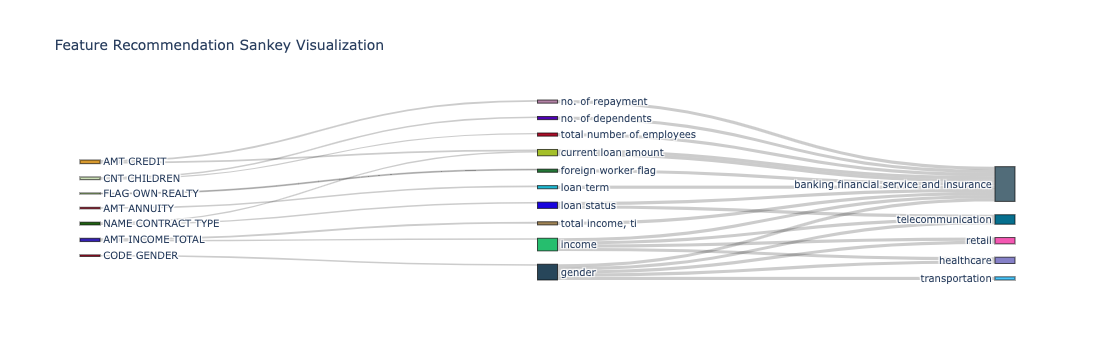

In [21]:
from anovos.feature_recommender.feature_recommendation import sankey_visualization
result_vis = result.iloc[4:, ].reset_index(drop=True).head(15)
sankey_visualization(result_vis, industry_included=True, usecase_included=False)

Because many attributes have similar description in the attribute description file, some recommended features are repeated. Thus, we can select `Recommended_Feature_Name` and `Recommended_Feature_Description` and perform deduplication.

In [22]:
result[['Recommended_Feature_Name', 'Recommended_Feature_Description']].drop_duplicates()\
    .reset_index(drop=True).sort_values('Recommended_Feature_Name')

Recommended_Feature_Name  \
5                                                 N/A   
20                                                age   
29                                     altman z-score   
46                                    annualized rate   
31                                     avg CA balance   
24                                 company's type, ct   
32                                     credit history   
25                                      credit rating   
30                                       credit score   
35                             current credit balance   
1                                 current loan amount   
41                            debt payment ratio, dpr   
16                                  employment status   
15                                    employment type   
6                                 foreign worker flag   
4                                              gender   
18                                            housing   
10                                             income   
40                            interest coverage ratio   
12                                      interest rate   
43                                        loan denied   
28                                      loan duration   
13                                       loan purpose   
0                                         loan status   
11                                          loan term   
26                                           location   
17                                     marital status   
38                                         max arrear   
37                                maximum open credit   
48                               microbusiness sector   
45                                 microcredit amount   
44                          microcredit interest rate   
27  monetary values of each product/ service used ...   
42                                       monthly debt   
19                             monthly household cost   
36                       months since last delinquent   
49                                no. annual payments   
7                                   no. of dependents   
2                                    no. of repayment   
33                          number of credit problems   
14                         other debtors / guarantors   
21                            payable turnover - days   
23                                              phone   
22                                previous loan grant   
3                            receivable turnover days   
47                                 sales in inventory   
39                               total debt to assets   
9                                    total income, ti   
8                           total number of employees   
34                            years of credit history   

                      Recommended_Feature_Description  
5                                                 N/A  
20                                    age of customer  
29                   1.2*X1+1.4*X2+3.3*X3+0.6*X4+1*X5  
46             Interest rate computed on annual scale  
31                 average balance in current account  
24       Applicant works in a credible company or not  
32  no credits taken/all credits paid back duly/ex...  
25                                      From AAA to C  
30  A value between 0 and 800 indicating the riski...  
35            The current total debt for the customer  
1   This is the loan amount that was either comple...  
41  Total debt divided by total income (i.e. DPR m...  
16              present employment status of customer  
15                                 type of employment  
6                                              yes/no  
4                                Gender of the client  
18  Categorical variable indicating home ownership...  
10                          annual income of customer  
40                                    EBIT / Interest  
1

In the above result, we can find some features related to clients' previous applications, for example:
- loan denied
- number of credit problems
- years of credit history
- previous loan grant
- credit history
- months since last delinquent

Below are the attributes that we can make use of to generate features above.

In [23]:
df_attr[df_attr['Table']=='previous_application.csv']

Table                          Row  \
173  previous_application.csv                  SK_ID_PREV    
174  previous_application.csv                   SK_ID_CURR   
175  previous_application.csv           NAME_CONTRACT_TYPE   
176  previous_application.csv                  AMT_ANNUITY   
177  previous_application.csv              AMT_APPLICATION   
178  previous_application.csv                   AMT_CREDIT   
179  previous_application.csv             AMT_DOWN_PAYMENT   
180  previous_application.csv              AMT_GOODS_PRICE   
181  previous_application.csv   WEEKDAY_APPR_PROCESS_START   
182  previous_application.csv      HOUR_APPR_PROCESS_START   
183  previous_application.csv  FLAG_LAST_APPL_PER_CONTRACT   
184  previous_application.csv       NFLAG_LAST_APPL_IN_DAY   
185  previous_application.csv             NFLAG_MICRO_CASH   
186  previous_application.csv            RATE_DOWN_PAYMENT   
187  previous_application.csv        RATE_INTEREST_PRIMARY   
188  previous_application.csv     RATE_INTEREST_PRIVILEGED   
189  previous_application.csv       NAME_CASH_LOAN_PURPOSE   
190  previous_application.csv         NAME_CONTRACT_STATUS   
191  previous_application.csv                DAYS_DECISION   
192  previous_application.csv            NAME_PAYMENT_TYPE   
193  previous_application.csv           CODE_REJECT_REASON   
194  previous_application.csv              NAME_TYPE_SUITE   
195  previous_application.csv             NAME_CLIENT_TYPE   
196  previous_application.csv          NAME_GOODS_CATEGORY   
197  previous_application.csv               NAME_PORTFOLIO   
198  previous_application.csv            NAME_PRODUCT_TYPE   
199  previous_application.csv                 CHANNEL_TYPE   
200  previous_application.csv             SELLERPLACE_AREA   
201  previous_application.csv         NAME_SELLER_INDUSTRY   
202  previous_application.csv                  CNT_PAYMENT   
203  previous_application.csv             NAME_YIELD_GROUP   
204  previous_application.csv          PRODUCT_COMBINATION   
205  previous_application.csv           DAYS_FIRST_DRAWING   
206  previous_application.csv               DAYS_FIRST_DUE   
207  previous_application.csv    DAYS_LAST_DUE_1ST_VERSION   
208  previous_application.csv                DAYS_LAST_DUE   
209  previous_application.csv             DAYS_TERMINATION   
210  previous_application.csv    NFLAG_INSURED_ON_APPROVAL   

                                           Description  \
173  ID of previous credit in Home credit related t...   
174                           ID of loan in our sample   
175  Contract product type (Cash loan, consumer loa...   
176                    Annuity of previous application   
177  For how much credit did client ask on the prev...   
178  Final credit amount on the previous applicatio...   
179           Down payment on the previous application   
180  Goods price of good that client asked for (if ...   
181  On which day of the week did the client apply ...   
182  Approximately at what day hour did the client ...   
183  Flag if it was last application for the previo...   
184  Flag if the application was the last applicati...   
185                            Flag Micro finance loan   
186    Down payment rate normalized on previous credit   
187        Interest rate normalized on previous credit   
188        Interest rate normalized on previous credit   
189                           Purpose of the cash loan   
190  Contract status (approved, cancelled, ...) of ...   
191  Relative to current application when was the d...   
192  Payment method that client chose to pay for th...   
193          Why was the previous application rejected   
194  Who accompanied client when applying for the p...   
195  Was the client old or new client when applying...   
196  What kind of goods did the client apply for in...   
197  Was the previous application for CASH, POS, CA...   
198      Was the previous application x-sell o walk-in   
199  Through which channel we acquired 

Out of the related features found above, we can generate the following using available attributes.
- `loan denied` - Count the number of "Refused" applications for attribute NAME_CONTRACT_STATUS
- `years of credit history` - Min DAYS_DECISION (Relative to current application when was the decision about previous application made) in Approved applications
- `previous loan grant` - Min & max & mean of AMT_CREDIT in Approved applications
- `credit history` - Count the number of "Approved" applications

Thus we can generate these features for each SK_ID_CURR found in previous_application and join back with the original dataframe.

In [13]:
# Load previous_application.csv
from pyspark.sql import functions as F

prev_app = read_dataset(
    spark,
    file_path=input_path+'previous_application.csv',
    file_type='csv',
    file_configs={'header': 'True', 'delimiter': ',', 'inferSchema': 'True'})

# Generate (17) loan denied
prev_app_refused = prev_app.where(F.col('NAME_CONTRACT_STATUS')=='Refused')\
    .groupBy('SK_ID_CURR').count().withColumnRenamed('count', 'CNT_PREV_REFUSED_APP')

# Generate the rest of the features
prev_app_rest = prev_app.where(F.col('NAME_CONTRACT_STATUS')=='Approved')\
    .groupBy('SK_ID_CURR')\
    .agg(F.min('DAYS_DECISION').alias('DAYS_PREV_CREDIT_HISTORY'),
         F.min('AMT_CREDIT').alias('AMT_PREV_CREDIT_MIN'),
         F.max('AMT_CREDIT').alias('AMT_PREV_CREDIT_MAX'),
         F.mean('AMT_CREDIT').alias('AMT_PREV_CREDIT_MEAN'),
         F.count('NAME_CONTRACT_STATUS').alias('CNT_PREV_APPROVED_APP')
        )

# Left join with the original dataframe and fill missing values in selected columns by 0.

from anovos.data_ingest.data_ingest import join_dataset
df = join_dataset(df, prev_app_refused, prev_app_rest, join_cols='SK_ID_CURR',join_type='left')\
    .na.fill(0, subset=['DAYS_PREV_CREDIT_HISTORY', 'CNT_PREV_APPROVED_APP', 'CNT_PREV_REFUSED_APP'])

### Feature generation based on domain knowledge
While the above modules solve the cold start problem, there may be cases where the modelers possess domain knowledge and would like to try out features that they have conceptualized. 

`expression_parser` provided by ANOVOS can help generate new features easily using their SQL expressions in a list. The generated features are named as f0, f1, ... and for easier understanding, we can rename them using `rename_column` from Anovos data ingest module.

In [14]:
from anovos.data_transformer.transformers import expression_parser
df = expression_parser(df, ['DAYS_EMPLOYED/DAYS_BIRTH', 'AMT_INCOME_TOTAL/AMT_CREDIT', 
                            'AMT_INCOME_TOTAL/CNT_FAM_MEMBERS', 'AMT_ANNUITY/AMT_INCOME_TOTAL', 
                            'AMT_ANNUITY/AMT_CREDIT', 'DAYS_EMPLOYED-DAYS_BIRTH'])

from anovos.data_ingest.data_ingest import rename_column
new_cols = ['DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 
            'PAYMENT_RATE', 'DAYS_START_EMPLOYED']
df = rename_column(df, list_of_cols=['f0','f1','f2','f3','f4','f5'], list_of_newcols=new_cols)

df.select(*new_cols).limit(10).toPandas()

DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  INCOME_PER_PERSON  \
0            0.067329            0.498036           202500.0   
1            0.070862            0.208736           135000.0   
2            0.011814            0.500000            67500.0   
3            0.159905            0.431748            67500.0   
4            0.152418            0.236842           121500.0   
5            0.093737            0.201837            49500.0   
6            0.227174            0.109564            57000.0   
7            0.023820            0.235294           180000.0   
8                 NaN            0.110336            56250.0   
9            0.139540            0.333333           135000.0   

   ANNUITY_INCOME_PERC  PAYMENT_RATE  DAYS_START_EMPLOYED  
0             0.121978      0.060749               8824.0  
1             0.132217      0.027598              15577.0  
2             0.100000      0.050000              18821.0  
3             0.219900      0.094941              15966.0  
4             0.179963      0.042623              16894.0  
5             0.277955      0.056101              15353.0  
6             0.241526      0.026463              10648.0  
7             0.116875      0.027500              18401.0  
8             0.300680      0.033176                  NaN  
9             0.150000      0.050000              12450.0

`feature_transformation` can be used to perform basic math transformations such as square, square root, log, exponential, power, etc.

In [15]:
from anovos.data_transformer.transformers import feature_transformation
sq_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CNT_CHILDREN']
df = feature_transformation(df, list_of_cols=sq_cols, method_type="sq", output_mode="append")

log_cols = ['AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_CREDIT']
df = feature_transformation(df, list_of_cols=log_cols, method_type="ln", output_mode="append")

new_cols = [col+'_sq' for col in sq_cols]+[col+'_ln' for col in log_cols]
df = feature_transformation(df, list_of_cols=new_cols, method_type="roundN", N=4, output_mode="replace")

df.select(*new_cols).limit(10).toPandas()

EXT_SOURCE_1_sq  EXT_SOURCE_2_sq  EXT_SOURCE_3_sq  CNT_CHILDREN_sq  \
0           0.0069           0.0691           0.0194              0.0   
1           0.0969           0.3872              NaN              0.0   
2              NaN           0.3090           0.5323              0.0   
3              NaN           0.4231              NaN              0.0   
4              NaN           0.1042              NaN              0.0   
5              NaN           0.1255           0.3859              0.0   
6           0.6003           0.5242           0.2421              1.0   
7              NaN           0.5102           0.2923              0.0   
8           0.3450           0.0423           0.5651              0.0   
9              NaN           0.5575              NaN              0.0   

   AMT_GOODS_PRICE_ln  AMT_INCOME_TOTAL_ln  AMT_ANNUITY_ln  AMT_CREDIT_ln  
0             12.7685              12.2185         10.1146        12.9156  
1             13.9373              12.5062         10.4829        14.0729  
2             11.8130              11.1199          8.8173        11.8130  
3             12.6015              11.8130         10.2984        12.6529  
4             13.1480              11.7077          9.9927        13.1480  
5             13.0270              11.5029         10.2226        13.1032  
6             14.1484              12.0494         10.6286        14.2607  
7             14.2408              12.7939         10.6472        14.2408  
8             13.7250              11.6307         10.4290        13.8349  
9             12.9116              11.8130          9.9159        12.9116

At this stage, we have our full candidate feature set. To reiterate, this set has three components:
* **The feature set suggested by the feature explorer/recommender**
    * loan denied, years of credit history, previous loan grant, credit history
* **Custom features that may have been generated by the modeler**
    * income per person, income credit percent, payment rate, etc
    * square of EXT_SOURCE_1, CNT_CHILDREN, etc
    * ln of AMT_GOODS_PRICE, AMT_INCOME_TOTAL, etc
* **All the base “characteristic” attributes in the original data set**
    * DAYS_EMPLOYED, DAYS_BIRTH, AMT_INCOME_TOTAL, AMT_CREDIT, etc
    
We now enter the final stage of feature engineering – running a set of checks to prune the above set down to our “model-ready” features. The first such check is the stability check.

---------

### Stability check
In practice when we create new features, we hope they are stable over time. Detailed introduction to data stability index can be found in [Anovos documentation](https://docs.anovos.ai/anovos-modules-overview/data_drift_and_stability_index/index.html). In short, we aim to calculate a stability index (SI) for each attribute from T1 to Tn and classify it to one of the following categories: 
- Very unstable (0≤SI<1)
- Unstable (1≤SI<2)
- Marginally stable (2≤SI<3)
- Stable (3≤SI<3.5)
- Very stable (3.5≤SI≤4). 

The prerequisite of the function is availability of historical data for the same from different time periods. In this case, we simulated the original dataset to generate historical datasets (`df1` - `df6`) for demonstration purpose. Statistics of historical data have already been saved and we can specify the path in `existing_metric_path`. More details can be found in the [example notebook](https://github.com/anovos/anovos/blob/main/examples/notebooks/drift__detector.ipynb)

In this demo, we will create `df7` and access the results for `df1` - `df6` directly. We will focus on the attributes used above to create new features.

In [16]:
from anovos.drift.detector import stability_index_computation
stability_input_path_fc = input_path+'pre_saved_stats/stability'
stability_output_path_fc = output_path+'stability_metrics_df1to7_fc'
df7 = df.sample(False, 0.0065, 7)
stability_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                  'DAYS_EMPLOYED', 'DAYS_BIRTH', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
                  'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

df_stability = stability_index_computation(spark, df7, list_of_cols=stability_cols, 
                                           existing_metric_path=stability_input_path_fc,
                                           appended_metric_path=stability_output_path_fc,
                                           threshold=2)\
               .orderBy('attribute')
df_stability.toPandas()

attribute  mean_cv  stddev_cv  kurtosis_cv  mean_si  stddev_si  \
0        AMT_ANNUITY   0.0287     0.0744       0.2919        4          3   
1         AMT_CREDIT   0.0304     0.0502       0.1175        3          3   
2    AMT_GOODS_PRICE   0.0319     0.0562       0.1257        3          3   
3   AMT_INCOME_TOTAL   0.0256     0.1199       0.6626        4          2   
4       CNT_CHILDREN   0.0396     0.0426       0.4840        3          3   
5    CNT_FAM_MEMBERS   0.0136     0.0305       0.3913        4          3   
6         DAYS_BIRTH  -0.0141     0.1455       1.0294        4          2   
7      DAYS_EMPLOYED   0.4305     0.4047       0.1290        1          1   
8       EXT_SOURCE_1   0.0236     0.0227       0.0403        4          4   
9       EXT_SOURCE_2   0.0147     0.0315       0.0575        4          3   
10      EXT_SOURCE_3   0.0206     0.0471       0.0785        4          3   

    kurtosis_si  stability_index  flagged  
0             1              3.1        0  
1             2              2.8        0  
2             2              2.8        0  
3             0              2.6        0  
4             1              2.6        0  
5             1              3.1        0  
6             0              2.6        0  
7             2              1.2        1  
8             3              3.8        0  
9             3              3.5        0  
10            3              3.5        0

From the results above, we can see that most attributes are stable from `df1` to `df7` except DAYS_EMPLOYED. 

To check whether the new features are stable as well, we can use `feature_stability_estimation` which reads the historical metrics of the attributes used to create the features. The idea is to be able to check their stability without reading the historical data again nor doing any back calculation. You can find more details in our [documentation](https://docs.anovos.ai/api/drift/detector.html).

In [18]:
from anovos.drift.detector import feature_stability_estimation

df_intermediate = read_dataset(spark, stability_output_path_fc, "csv",{'header':True,'inferSchema':True})

transformations = {'DAYS_EMPLOYED|DAYS_BIRTH': 'DAYS_EMPLOYED/DAYS_BIRTH',
                   'AMT_INCOME_TOTAL|AMT_CREDIT': 'AMT_INCOME_TOTAL/AMT_CREDIT',
                   'AMT_INCOME_TOTAL|CNT_FAM_MEMBERS': 'AMT_INCOME_TOTAL/CNT_FAM_MEMBERS', 
                   'AMT_ANNUITY|AMT_INCOME_TOTAL': 'AMT_ANNUITY/AMT_INCOME_TOTAL', 
                   'AMT_ANNUITY|AMT_CREDIT': 'AMT_ANNUITY/AMT_CREDIT', 
                   'DAYS_EMPLOYED|DAYS_BIRTH': 'DAYS_EMPLOYED-DAYS_BIRTH',
                   'EXT_SOURCE_1': 'EXT_SOURCE_1**2', 
                   'EXT_SOURCE_2': 'EXT_SOURCE_2**2', 
                   'EXT_SOURCE_3': 'EXT_SOURCE_3**2',
                   'CNT_CHILDREN': 'CNT_CHILDREN**2',
                   'AMT_ANNUITY': 'ln(AMT_ANNUITY)', 
                   'AMT_CREDIT': 'ln(AMT_CREDIT)', 
                   'AMT_GOODS_PRICE': 'ln(AMT_GOODS_PRICE)', 
                   'AMT_INCOME_TOTAL': 'ln(AMT_INCOME_TOTAL)'}

feature_stability_estimation(spark, df_intermediate, transformations, threshold=2).toPandas()

feature_formula  mean_cv  stddev_cv  mean_si  stddev_si  \
0           DAYS_EMPLOYED-DAYS_BIRTH   0.3336     0.3960        1          1   
1        AMT_INCOME_TOTAL/AMT_CREDIT   0.0202     0.0410        4          3   
2   AMT_INCOME_TOTAL/CNT_FAM_MEMBERS   0.0408     0.0972        3          3   
3       AMT_ANNUITY/AMT_INCOME_TOTAL   0.0579     0.0782        3          3   
4             AMT_ANNUITY/AMT_CREDIT   0.0206     0.0387        4          3   
5                    EXT_SOURCE_1**2   0.0424     0.0364        3          3   
6                    EXT_SOURCE_2**2   0.0207     0.0232        4          4   
7                    EXT_SOURCE_3**2   0.0292     0.0361        4          3   
8                    CNT_CHILDREN**2   0.0782     0.0739        3          3   
9                    ln(AMT_ANNUITY)   0.0024     0.0545        4          3   
10                    ln(AMT_CREDIT)   0.0024     0.0336        4          3   
11               ln(AMT_GOODS_PRICE)   0.0023     0.0363        4          3   
12              ln(AMT_INCOME_TOTAL)   0.0016     0.0977        4          3   

    stability_index_lower_bound  stability_index_upper_bound  flagged_lower  \
0                           0.8                          1.6              1   
1                           2.9                          3.7              0   
2                           2.4                          3.2              0   
3                           2.4                          3.2              0   
4                           2.9                          3.7              0   
5                           2.4                          3.2              0   
6                           3.2                          4.0              0   
7                           2.9                          3.7              0   
8                           2.4                          3.2              0   
9                           2.9                          3.7              0   
10                          2.9                          3.7              0   
11                          2.9                          3.7              0   
12                          2.9                          3.7              0   

    flagged_upper  
0               1  
1               0  
2               0  
3               0  
4               0  
5               0  
6               0  
7               0  
8               0  
9               0  
10              0  
11              0  
12              0

One limitation of this function is that it can only output a range for estimated stability index but we can get some insights from the lower and upper bound.

The result shows that some new features might not be stable, such as `DAYS_EMPLOYED-DAYS_BIRTH`.

## Data Transformation
![workflow](assets/img/workflow3.png)
### Cardinality Treatment

We have applied treatment for outliers in numerical features. It is also necessary to perform outlier treatment in categorical features especially when the number of classes within a feature is too large. Using Anovos, we can apply `outlier_categories` provided to limit the number of classes. 

In this example, we use two inputs to control the result: coverage=0.95 and max_category=15. It can be interpreted as top frequently seen categories are considered till it covers minimum 80% of rows and rest lesser seen values are mapped to others. However, maximally 14 categories can be mapped to actual name and rest to others even if the coverage does not reach 95%.

In [29]:
from anovos.data_transformer.transformers import outlier_categories

df = outlier_categories(spark, df, coverage=0.95, max_category=15, 
                        pre_existing_model=False, model_path=output_path, print_impact=True)

+--------------------------+-------------------+
|attribute                 |uniqueValues_before|
+--------------------------+-------------------+
|FLAG_OWN_CAR              |2                  |
|NAME_INCOME_TYPE          |8                  |
|WEEKDAY_APPR_PROCESS_START|7                  |
|EMERGENCYSTATE_MODE       |2                  |
|NAME_FAMILY_STATUS        |5                  |
|FONDKAPREMONT_MODE        |3                  |
|NAME_CONTRACT_TYPE        |2                  |
|NAME_HOUSING_TYPE         |6                  |
|ORGANIZATION_TYPE         |57                 |
|FLAG_OWN_REALTY           |2                  |
|WALLSMATERIAL_MODE        |7                  |
|CODE_GENDER               |2                  |
|NAME_EDUCATION_TYPE       |5                  |
|HOUSETYPE_MODE            |3                  |
|OCCUPATION_TYPE           |18                 |
|NAME_TYPE_SUITE           |7                  |
+--------------------------+-------------------+

+------------------

### Handle Missing Values
#### Remove columns with > 60% missing values
It is hard to impute an extremely sparse column. Thus, we can use `nullColumns_detection` to detect and treat columns with high proportion of missing values. In this case, we will let the function delete columns which contain >60% missing values. 

In [30]:
from anovos.data_analyzer.quality_checker import nullColumns_detection
df, odf_stats = nullColumns_detection(spark, df, treatment=True, treatment_method='column_removal', 
                                       treatment_configs={'treatment_threshold':0.6}, print_impact=True)
print(len(df.columns), 'columns are kept.')

+--------------------+-------------+-----------+
|           attribute|missing_count|missing_pct|
+--------------------+-------------+-----------+
|         AMT_ANNUITY|           12|        0.0|
|      AMT_ANNUITY_ln|           12|        0.0|
|     AMT_GOODS_PRICE|          278|     9.0E-4|
|  AMT_GOODS_PRICE_ln|          278|     9.0E-4|
| AMT_PREV_CREDIT_MAX|        17446|     0.0567|
|AMT_PREV_CREDIT_MEAN|        17446|     0.0567|
| AMT_PREV_CREDIT_MIN|        17446|     0.0567|
|AMT_REQ_CREDIT_BU...|        41519|      0.135|
|AMT_REQ_CREDIT_BU...|        41519|      0.135|
|AMT_REQ_CREDIT_BU...|        41519|      0.135|
|AMT_REQ_CREDIT_BU...|        41519|      0.135|
|AMT_REQ_CREDIT_BU...|        41519|      0.135|
|AMT_REQ_CREDIT_BU...|        41519|      0.135|
| ANNUITY_INCOME_PERC|           12|        0.0|
|      APARTMENTS_AVG|       156061|     0.5075|
|     APARTMENTS_MEDI|       156061|     0.5075|
|     APARTMENTS_MODE|       156061|     0.5075|
|    BASEMENTAREA_AV

We can observe that most of the deleted columns are related to "normalized information about building where the client lives, that is average (_AVG suffix), mode (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor", according to the column description. 

#### Detect row-wise null values
We can also remove rows with too many missing values using 'nullRows_detection'

In [31]:
from anovos.data_analyzer.quality_checker import nullRows_detection
odf, odf_stats = nullRows_detection(spark, df, treatment=False, treatment_threshold=0.4)
odf_stats.toPandas()

null_cols_count  row_count  row_pct  flagged
0                 0      29486   0.0959        0
1                 1       6160   0.0200        0
2                 2      29918   0.0973        0
3                 3      12030   0.0391        0
4                 4       4114   0.0134        0
5                 5      11294   0.0367        0
6                 6       4610   0.0150        0
7                 7      12611   0.0410        0
8                 8       8413   0.0274        0
9                 9       4541   0.0148        0
10               10       7929   0.0258        0
11               11       4245   0.0138        0
12               12       2163   0.0070        0
13               13       3498   0.0114        0
14               14       2230   0.0073        0
15               15       3098   0.0101        0
16               16       1851   0.0060        0
17               17       1319   0.0043        0
18               18       1198   0.0039        0
19               19       1146   0.0037        0
20               20        696   0.0023        0
21               21        694   0.0023        0
22               22        801   0.0026        0
23               23        932   0.0030        0
24               24        654   0.0021        0
25               25        816   0.0027        0
26               26        422   0.0014        0
27               27        314   0.0010        0
28               28        334   0.0011        0
29               29        360   0.0012        0
30               30        975   0.0032        0
31               31      35872   0.1167        0
32               32       7534   0.0245        0
33               33      42872   0.1394        0
34               34       9638   0.0313        0
35               35       3988   0.0130        0
36               36       7434   0.0242        0
37               37        838   0.0027        0
38               38      16528   0.0537        0
39               39       6088   0.0198        0
40               40       2505   0.0081        0
41               41       8923   0.0290        0
42               42       1900   0.0062        0
43               43        197   0.0006        0
44               44       1079   0.0035        0
45               45        129   0.0004        0
46               46       2954   0.0096        0
47               47         33   0.0001        0
48               48         19   0.0001        0
49               49        117   0.0004        0
50               50          4   0.0000        0
51               51          4   0.0000        1
52               53          3   0.0000        1

All rows have fill rate > 50% and less 10 rows are flagged out so we can proceed without treatment.

#### Impute categorical attributes using mode
To handle the rest of the missing values, we will use `imputation_MMM` to impute them. It is recommended to explicitly pass the columns to impute through `list_of_cols` if the saved model may be applied on another dataset.

In [32]:
from anovos.data_transformer.transformers import imputation_MMM
from anovos.shared.utils import attributeType_segregation
cat_cols = attributeType_segregation(df)[1]
# print(cat_cols)
df = imputation_MMM(spark, df, list_of_cols=cat_cols, pre_existing_model=False, model_path=output_path)

#### Impute numerical attributes using KNN

In interest of time during demo, we have used sample dataset for computation. Please feel free to change it to original dataset though it may take longer time to finish.

In [18]:
# Generate sample data
from anovos.data_analyzer.stats_generator import measures_of_counts
from anovos.data_ingest.data_ingest import write_dataset
import pyspark.sql.functions as F

df_model = df.sample(False, 0.0165, 13)
write_dataset(df_model, output_path+'application_train_model', 'parquet',{'mode':'overwrite'})
df_model = read_dataset(spark, file_path=output_path+'application_train_model', file_type='parquet')

K-Nearest Neighbors algorithm (KNN) imputes missing values of a sample using the mean of its 5 nearest neighbors in the training set. `normalization` is applied before running imputation to normalize each attribute to have min value of 0 and max value of 1.

In [19]:
from anovos.data_transformer.transformers import normalization
df_model = normalization(df_model, drop_cols=['SK_ID_CURR', 'TARGET'],
                         pre_existing_model=False, model_path=output_path+'normalization_num/')

from anovos.data_transformer.transformers import imputation_sklearn
df_model = imputation_sklearn(spark, df_model, method_type="KNN", 
                              pre_existing_model=False, model_path=output_path)

In [20]:
odf = measures_of_counts(spark, df_model)
odf.where(F.col('missing_count')>0).toPandas()

Empty DataFrame
Columns: [attribute, fill_count, fill_pct, missing_count, missing_pct, nonzero_count, nonzero_pct]
Index: []

There is no columns with `missing_pct` > 0, which indicates that there is no more missing values in dataframe `df`!

Anovos also supports `auto_imputation` which automatically find the optimal imputation method by evaluating 5 different methodologies. These methodologies can also be used independently by calling their corresponding functions from the transformers module:
* imputation using mean (imputation_MMM with method_type="mean")
* imputation using median (imputation_MMM with method_type="median" )
* imputation using K-Nearest Neighbors algorithm (imputation_sklearn with method_type="KNN")
* imputation using sklearn IterativeImputer (imputation_sklearn with method_type="regression")
* imputation using matrix factorization (imputation_matrixFactorization)

For other imputation methods supported by Anovos, please refer to [transformers documentation](https://docs.anovos.ai/api/data_transformer/transformers.html).

### Categorical Attributes Encoding
Most machine learning models cannot handle catigorical attributes so we need to convert them to numerical attributes. To control the dimensionality of the dataset, we will use a WOE based supervised method. For each attribute, the positive event rate for each categorical value is used as the encoded numerical value. Subsequently, we will apply normalization to transform the min and max values for each column to 0 and 1 respectively.

In addition, 2 other common encoding techniques: label encoding and one-hot encoding are also supported by function `cat_to_num_unsupervised`.

In [21]:
from anovos.shared.utils import attributeType_segregation
cat_cols = attributeType_segregation(df_model)[1]

from anovos.data_transformer.transformers import cat_to_num_supervised
df_model = cat_to_num_supervised(spark, df_model, label_col='TARGET', event_label=1,
                                 pre_existing_model=False, model_path=output_path, 
                                 print_impact=False)

from anovos.data_transformer.transformers import normalization
df_model = normalization(df_model, list_of_cols=cat_cols, pre_existing_model=False, 
                         model_path=output_path+'normalization_cat/')

df_model.select(cat_cols).describe().toPandas()

summary        FLAG_OWN_CAR     NAME_INCOME_TYPE WEEKDAY_APPR_PROCESS_START  \
0   count                5095                 5095                       5095   
1    mean  0.6698724239450442   0.8619851827504473        0.30147547550477505   
2  stddev  0.4703049777534146  0.17233997032517331        0.34513046183076135   
3     min                 0.0                  0.0                        0.0   
4     max                 1.0                  1.0                        1.0   

   NAME_CONTRACT_TYPE    NAME_HOUSING_TYPE     FLAG_OWN_REALTY  \
0                5095                 5095                5095   
1  0.9061825318940138  0.05551950812752891  0.6971540726202159   
2   0.291603223874155  0.21273355476065278  0.4595342408382066   
3                 0.0                  0.0                 0.0   
4                 1.0                  1.0                 1.0   

   NAME_EDUCATION_TYPE   EMERGENCYSTATE_MODE    ORGANIZATION_TYPE  \
0                 5095                  5095                 5095   
1   0.5063764064187976  0.006673209028459273   0.4146916942546643   
2  0.29665130951498386   0.08142468041864472  0.17689992129211865   
3                  0.0                   0.0                  0.0   
4                  1.0                   1.0                  1.0   

    WALLSMATERIAL_MODE         CODE_GENDER       HOUSETYPE_MODE  \
0                 5095                5095                 5095   
1   0.3548115360842135  0.3434739941118744   0.9915603532875368   
2  0.12528002404291969  0.4749145998703841  0.09148804225155548   
3                  0.0                 0.0                  0.0   
4                  1.0                 1.0                  1.0   

    NAME_FAMILY_STATUS      OCCUPATION_TYPE     NAME_TYPE_SUITE  
0                 5095                 5095                5095  
1  0.35024042668824573   0.5231522013880203   0.837315996074583  
2  0.32674953718957994  0.17106403415424618  0.3386508055925005  
3                  0.0                  0.0                 0.0  
4                  1.0                  1.0                 1.0

## Dimensionality Reduction
![workflow](assets/img/workflow4.png)
### Remove correlated features (Variable Clustering)
According to the documentation, there are more than 40 columns measuring normalized information about building where the client lives including apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building and number of floor. In addition, 3 kinds of measurement are taken for each metric: mean, mode and median so they could be highly correlated with each other. Some of them have been removed because of their low fill rate. 

For the rest of them, we can use `variable_clustering` to group features that are highly correlated into one cluster and select the feature with the highest RS_Ratio within each cluster. This helps reduce the correlation between features as well as the dimensionality of the dataset. 

In [22]:
from anovos.data_analyzer.association_evaluator import variable_clustering

info_cols = sorted([i for i in df_model.columns if i.endswith('_AVG')|i.endswith('_MEDI')|i.endswith('_MODE')])
odf_var_cluster = variable_clustering(spark, df_model, list_of_cols=info_cols)

odf_var_cluster.toPandas()

Cluster                     Attribute  RS_Ratio
0         0                ELEVATORS_MEDI    0.2354
1         0               APARTMENTS_MEDI    0.1413
2         0                ELEVATORS_MODE    0.2431
3         0               LIVINGAREA_MEDI    0.0927
4         0               APARTMENTS_MODE    0.1751
5         0               LIVINGAREA_MODE    0.1295
6         0                LIVINGAREA_AVG    0.0977
7         0                APARTMENTS_AVG    0.1384
8         0                 ELEVATORS_AVG    0.2334
9         0                TOTALAREA_MODE    0.1726
10        1                 ENTRANCES_AVG    0.0101
11        1                ENTRANCES_MODE    0.0206
12        1                ENTRANCES_MEDI    0.0057
13        2  YEARS_BEGINEXPLUATATION_MODE    0.0452
14        2  YEARS_BEGINEXPLUATATION_MEDI    0.0280
15        2   YEARS_BEGINEXPLUATATION_AVG    0.0083
16        3            NONLIVINGAREA_MEDI    0.0072
17        3             NONLIVINGAREA_AVG    0.0207
18        3            NONLIVINGAREA_MODE    0.0195
19        3            WALLSMATERIAL_MODE    0.9995
20        4                 LANDAREA_MODE    0.0201
21        4                  LANDAREA_AVG    0.0376
22        4                 LANDAREA_MEDI    0.0100
23        5                 FLOORSMAX_AVG    0.0074
24        5                FLOORSMAX_MEDI    0.0045
25        5                FLOORSMAX_MODE    0.0136
26        6              BASEMENTAREA_AVG    0.0128
27        6             BASEMENTAREA_MEDI    0.0077
28        6             BASEMENTAREA_MODE    0.0197

As we can observe from the obove results, 7 clusters are formed for housing info features so we will keep one feature in each cluster and drop the rest.

In [11]:
# Select one feature from each cluster with highest RS_Ratio
from pyspark.sql.window import Window
w = Window.partitionBy('Cluster').orderBy(F.desc('RS_Ratio'))
selected_info_cols = odf_var_cluster.withColumn('rank', F.row_number().over(w))\
    .where(F.col('rank')==1)\
    .select('Attribute').rdd.flatMap(lambda x: x).collect()
dropped_info_cols = [i for i in info_cols if i not in selected_info_cols]

df_model = df_model.drop(*dropped_info_cols)
print(len(df_model.columns), 'columns are kept.')

98 columns are kept.


### Remove features with low importance (IV Calculation)
Another way to reduce the dimensionality is by removing features with low information value using function `IV_calculation`. In this notebook we will only focus on selected columns (binary attributes starting with "FLAG_").

In [12]:
from anovos.data_analyzer.association_evaluator import IV_calculation
flag_cols = [i for i in df_model.columns if i.startswith('FLAG_')]+['TARGET']
odf_iv = IV_calculation(spark, df_model, list_of_cols=flag_cols, label_col='TARGET', event_label=1)
odf_iv.toPandas()

attribute      iv
0         FLAG_PHONE  0.0450
1    FLAG_DOCUMENT_3  0.0258
2     FLAG_EMP_PHONE  0.0214
3         FLAG_EMAIL  0.0067
4    FLAG_DOCUMENT_6  0.0060
5    FLAG_DOCUMENT_5  0.0040
6    FLAG_DOCUMENT_8  0.0033
7    FLAG_WORK_PHONE  0.0027
8   FLAG_DOCUMENT_11  0.0019
9   FLAG_DOCUMENT_18  0.0001
10  FLAG_DOCUMENT_16  0.0001
11  FLAG_CONT_MOBILE  0.0000
12  FLAG_DOCUMENT_19  0.0000
13   FLAG_DOCUMENT_9  0.0000
14  FLAG_DOCUMENT_15  0.0000
15      FLAG_OWN_CAR  0.0000
16  FLAG_DOCUMENT_20  0.0000
17  FLAG_DOCUMENT_14  0.0000
18   FLAG_DOCUMENT_4  0.0000
19  FLAG_DOCUMENT_17  0.0000
20        FLAG_MOBIL  0.0000
21   FLAG_DOCUMENT_2  0.0000
22   FLAG_DOCUMENT_7  0.0000
23   FLAG_OWN_REALTY  0.0000
24  FLAG_DOCUMENT_13  0.0000
25  FLAG_DOCUMENT_21  0.0000
26  FLAG_DOCUMENT_12  0.0000
27  FLAG_DOCUMENT_10  0.0000

As we can see, many features have nearly 0 Information Value, so we can drop them to reduce the dimensionality.

In [13]:
zero_iv_cols = odf_iv.where(F.col('iv')<=0.001).select('attribute').rdd.flatMap(lambda x: x).collect()
# print(zero_iv_cols)
df_model = df_model.drop(*zero_iv_cols)
print(len(df_model.columns), 'columns are kept.')

79 columns are kept.


### Generate latent features
An alternative way to reduce data dimensionality is to create latent features. In Anovos, latent features can be generated using Principal Component Analysis or autoencoder implemented in TensorFlow. 

In this example, we will apply autoencoder on selected features related to amount of money.

In [14]:
from anovos.data_transformer.transformers import autoencoder_latentFeatures
amt_cols = sorted([i for i in df_model.columns if i.startswith('AMT_INCOME')|i.startswith('AMT_CREDIT')|i.startswith('AMT_ANNUITY')|i.startswith('AMT_GOODS')])
df_model = autoencoder_latentFeatures(spark, df_model, list_of_cols=amt_cols, 
                                      sample_size=2000, epochs=50, standardization=False,
                                      pre_existing_model=False, model_path=output_path, 
                                      print_impact=True)

Epoch 1/50
7/7 - 2s - loss: 121254117376.0000 - val_loss: 129417404416.0000 - 2s/epoch - 282ms/step
Epoch 2/50
7/7 - 0s - loss: 121254051840.0000 - val_loss: 129417420800.0000 - 56ms/epoch - 8ms/step
Epoch 3/50
7/7 - 0s - loss: 121254002688.0000 - val_loss: 129417306112.0000 - 197ms/epoch - 28ms/step
Epoch 4/50
7/7 - 0s - loss: 121253937152.0000 - val_loss: 129417150464.0000 - 55ms/epoch - 8ms/step
Epoch 5/50
7/7 - 0s - loss: 121253855232.0000 - val_loss: 129417043968.0000 - 52ms/epoch - 7ms/step
Epoch 6/50
7/7 - 0s - loss: 121253781504.0000 - val_loss: 129416937472.0000 - 52ms/epoch - 7ms/step
Epoch 7/50
7/7 - 0s - loss: 121253715968.0000 - val_loss: 129416896512.0000 - 56ms/epoch - 8ms/step
Epoch 8/50
7/7 - 0s - loss: 121253650432.0000 - val_loss: 129416847360.0000 - 49ms/epoch - 7ms/step
Epoch 9/50
7/7 - 0s - loss: 121253601280.0000 - val_loss: 129416863744.0000 - 48ms/epoch - 7ms/step
Epoch 10/50
7/7 - 0s - loss: 121253552128.0000 - val_loss: 129416863744.0000 - 50ms/epoch - 7ms/st

2022-03-24 15:29:38,615 WARNING [saving_utils]: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


2022-03-24 15:29:38,735 WARNING [saving_utils]: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


+-------+--------------------+------------------+-------------------+-------------------+
|summary|latent_0            |latent_1          |latent_2           |latent_3           |
+-------+--------------------+------------------+-------------------+-------------------+
|count  |5095                |5095              |5095               |5095               |
|mean   |-0.03328137989992219|1.1003922726706739|0.12538099118469098|0.12374625663383625|
|stddev |0.7780760669597989  |1.7439711989675273|0.31144550239536944|0.44605306951752144|
|min    |-7.077481           |-0.54262346       |-0.47876826        |-2.161667          |
|max    |1.9087502           |13.05795          |1.8675833          |3.645737           |
+-------+--------------------+------------------+-------------------+-------------------+



## Summary
All the steps above can be summarized into this diagram below.
![summary](assets/img/summary.png)